# Library

In [1]:
# Ignore the warnings
import warnings
# warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# System related and data input controls
import os

# Python path
import sys
base_folder = 'DataScience'
location_base = os.path.join(os.getcwd().split(base_folder)[0], base_folder)
location_module = [os.path.join(location_base, 'Module')] 
for each in location_module:
    if each not in sys.path:
        sys.path.append(each)

# Auto reload of library
%reload_ext autoreload
%autoreload 2

from module_KK import * 
from preprocessing_KK import *
from algorithm_machinelearning_KK import *
from algorithm_deeplearning_KK import *

JAVA is in the system path?:  False
JAVA is in the system path?:  Adding...
Operation Machine:  Intel64 Family 6 Model 186 Stepping 2, GenuineIntel
Operation Platform:  64bit
OS Type:  Windows
OS Version:  10
Python Version:  3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]


2024-05-30 11:06:24,401	INFO worker.py:1642 -- Started a local Ray instance.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KK\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\KK\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 1D Modeling

In [2]:
target_dow = '전체'
target_line = '경부선'
Y_colname = '승차인원수'
# X_colname = ['일수', '주말수', '주중수', '공휴일수', '명절수']
# X_colname = ['일수', '주말수', '주중수', '공휴일수', '명절수',
#              'stringency_index', 'people_fully_vaccinated',
#              'international_movement_restrictions', 'confirmed',
#              'containment_health_index', 'people_vaccinated',
#              'government_response_index', 'deaths']
X_colname = None
date_train = '2023-03-31'
date_validate = '2024-03-31'
date_test = '2025-12-31'
SEQUENCE = 12
FORECASTING_PERIOD = 21

# df = preprocessing_KTX()
df = pd.read_csv(os.path.join('.', 'Data', 'df_KTX_KK.csv')).iloc[:,1:]

# 데이터분리
df = df.set_index('운행년월')
df = df[(df['전체주중주말'] == target_dow) & (df['주운행선'] == target_line)].iloc[:,2:]
df_train = df[df.index <= date_train]
df_validate = df[(df.index > date_train) & (df.index <= date_validate)]
df_test = df[(df.index > date_validate) & (df.index <= date_test)]

model, Score_te = modeling_RandomForestRegressor_MovingWindow(df_train[[Y_colname]], 
                                                              SEQUENCE=SEQUENCE, FORECASTING_PERIOD=FORECASTING_PERIOD)
display(Score_te)

model, Score_te = modeling_XGBRegressor_MovingWindow(df_train[[Y_colname]], 
                                                     SEQUENCE=SEQUENCE, FORECASTING_PERIOD=FORECASTING_PERIOD)
display(Score_te)    

100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:02<00:00, 17.43it/s]


MAE                    MSE   MAPE
Score 871,982.0173 1,040,290,767,486.8444 0.2953

100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:02<00:00, 13.83it/s]


MAE                    MSE   MAPE
Score 948,327.4000 1,224,222,108,163.8171 0.3219

# 2D Modeling

## Preprocessing

In [3]:
target_dow = '전체'
target_line = '경부선'
Y_colname = '승차인원수'
# X_colname = ['일수', '주말수', '주중수', '공휴일수', '명절수']
X_colname = ['일수', '주말수', '주중수', '공휴일수', '명절수',
             'stringency_index', 'people_fully_vaccinated',
             'international_movement_restrictions', 'confirmed',
             'containment_health_index', 'people_vaccinated',
             'government_response_index', 'deaths']
date_train = '2023-03-31'
date_validate = '2024-03-31'
date_test = '2025-12-31'
LAG_LENGTH = 6

# df = preprocessing_KTX()
df = pd.read_csv(os.path.join('.', 'Data', 'df_KTX_KK.csv')).iloc[:,1:]

# 데이터분리
df = df.set_index('운행년월')
df = df[(df['전체주중주말'] == target_dow) & (df['주운행선'] == target_line)].iloc[:,2:]
if LAG_LENGTH != None:
    df, lag_colname = feature_lagging(df, Y_colname, direction='upward', lag_length=LAG_LENGTH)
    X_colname = X_colname + lag_colname
df_train = df[df.index <= date_train]
df_validate = df[(df.index > date_train) & (df.index <= date_validate)]
df_test = df[(df.index > date_validate) & (df.index <= date_test)]
Y_train, X_train = df_train[[Y_colname]], df_train[X_colname]
Y_validate, X_validate = df_validate[[Y_colname]], df_validate[X_colname]
Y_test, X_test = df_test[[Y_colname]], df_test[X_colname]

# 스케일링
scaler = preprocessing.MinMaxScaler()
scaler_fit = scaler.fit(X_train)
X_train = pd.DataFrame(scaler_fit.transform(X_train), 
                       index=X_train.index, columns=X_train.columns)
X_validate = pd.DataFrame(scaler_fit.transform(X_validate), 
                       index=X_validate.index, columns=X_validate.columns)
X_test = pd.DataFrame(scaler_fit.transform(X_test), 
                      index=X_test.index, columns=X_test.columns)

## Hyperparameters

In [4]:
################
SHAP = False
X_TOP_DISPLAY = 20
DEPENDENCY = False
################
tf.random.set_seed(123)
NODE_MLP = [128, 256, 128, 64, 32, 10]
NODE_CNN1 = [128, 256, 128]
NODE_CNN2 = [64, 32, 10]
KERNEL_SIZE = 5
STRIDE = 1
PADDING = 'same'
POOL_SIZE = 2
POOL_STRIDE = 2
HIDDEN_ACTIVATION = 'relu'
OUTPUT_ACTIVATION = 'linear'
REGULARIZER = None
# REGULARIZER = regularizers.l2(0.001)
DROPOUT_RATIO = 0.25
LOSS = 'mse'
LEARNING_RATE = 0.001
OPTIMIZER = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
METRICS = ['mse']    # 'accuracy', 'Precision', 'Recall', 'AUC', 'F1Score'
VALIDATION_SPLIT = None
VALIDATION_DATA = (X_validate, Y_validate)
BATCH_SIZE = 12
EPOCHS = 1000
VERBOSE = 0
################
MONITOR = 'val_loss'    # 'val_accuracy', 'val_precision', 'val_recall', 'val_f1'
MONITOR_MODE = 'min'
EARLYSTOP_PATIENT = 200

## Random Forest

Explanations of Y:


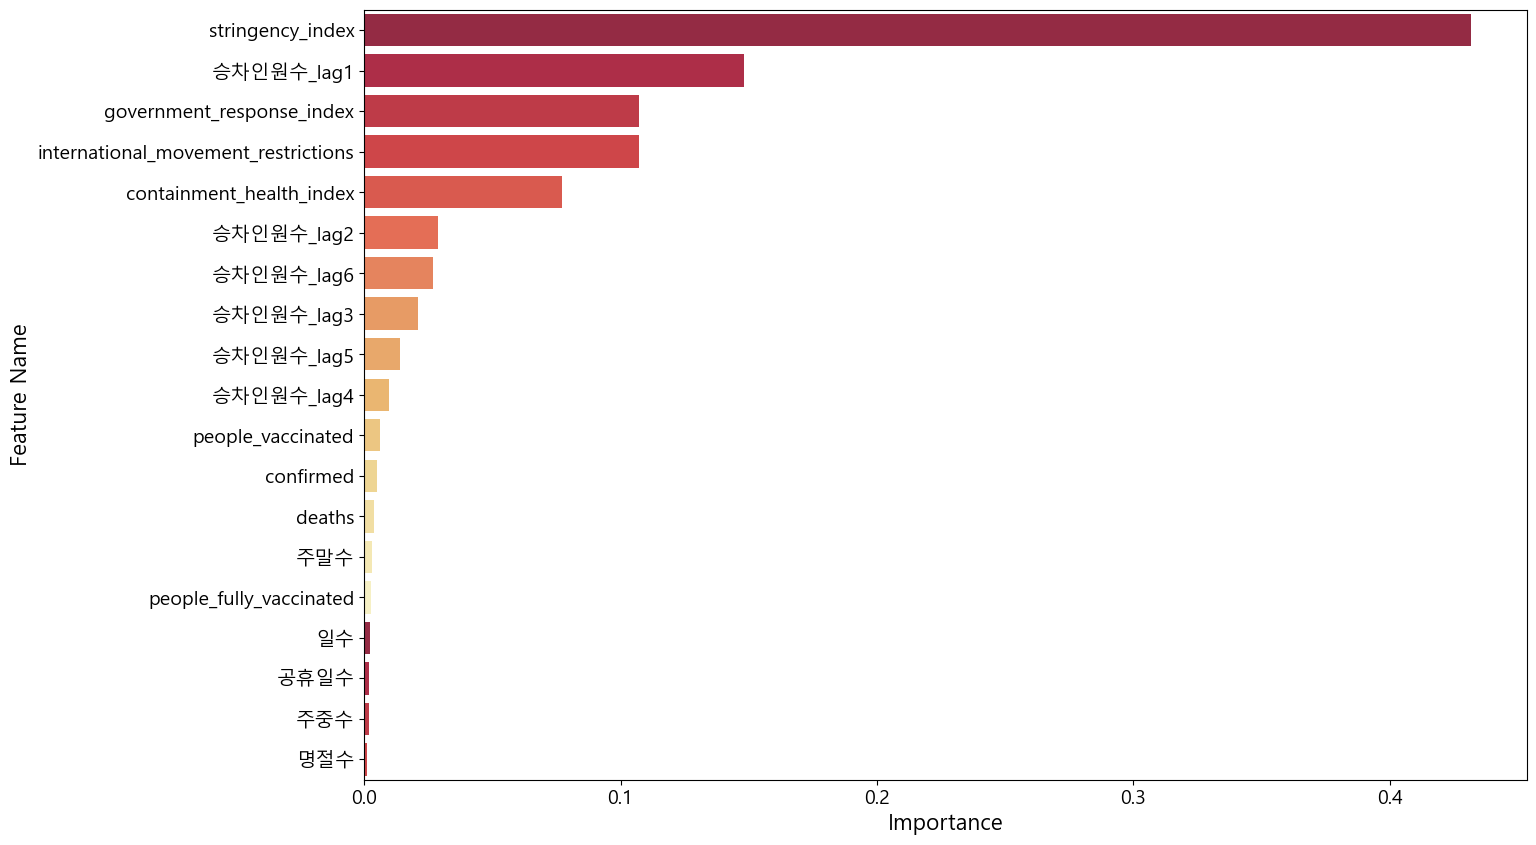

Performance: 


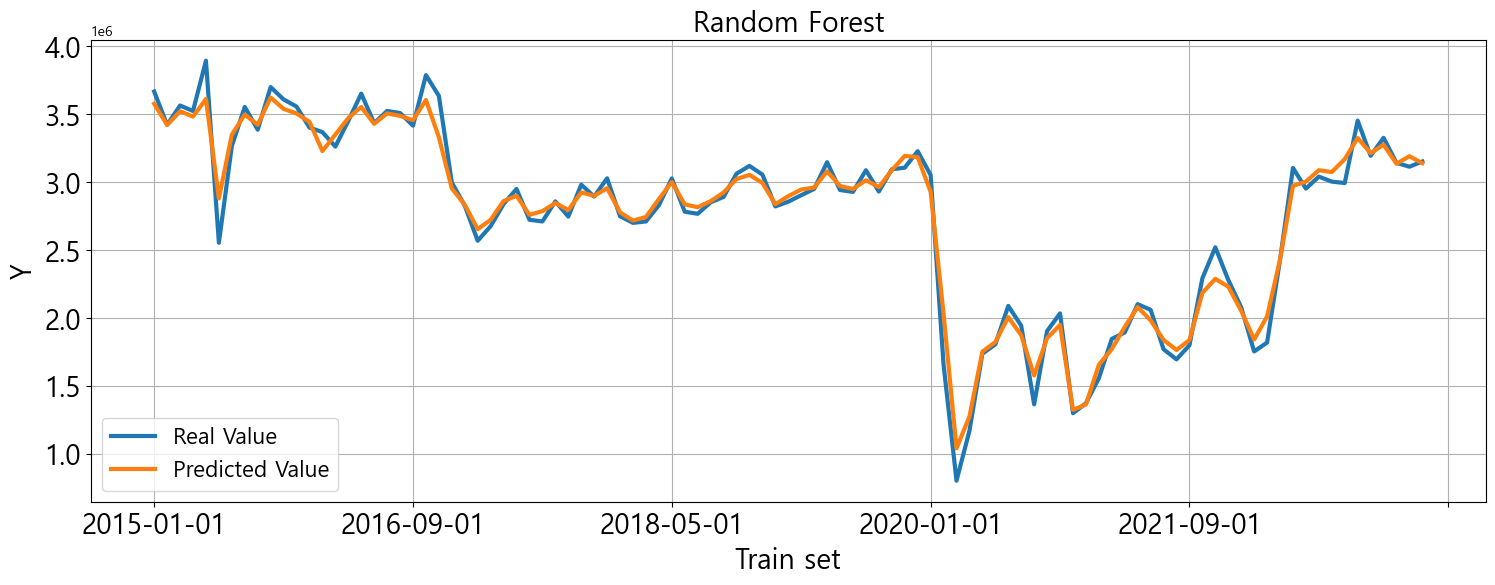

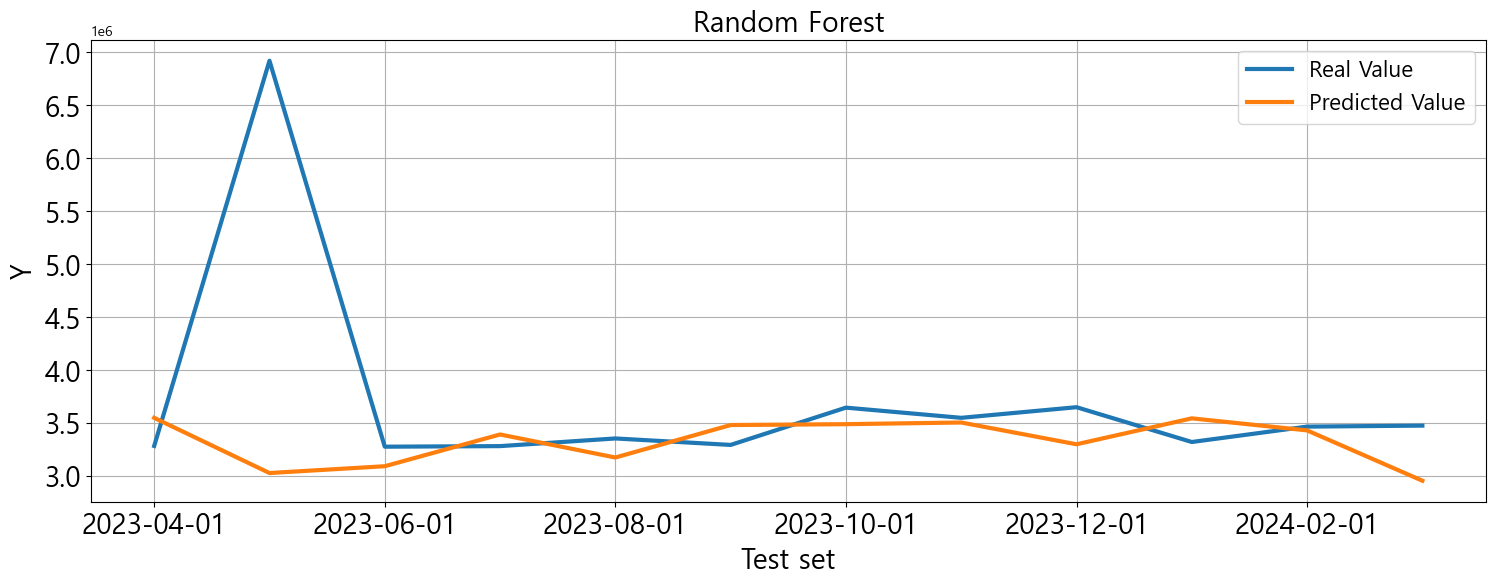

MAE                    MSE   MAPE
Score 512,898.9700 1,319,661,584,956.5964 0.1020

MAE                  MSE   MAPE
Score 118,325.0539 151,606,940,454.6533 0.0380

In [203]:
model_rf, Score_te_rf, Score_trte_rf = modeling_RandomForestRegressor(X_train, Y_train, X_validate, Y_validate,
                                                                      X_colname, shap=SHAP, X_top_display=X_TOP_DISPLAY)
display(Score_te_rf, Score_trte_rf)

## XGBoost

Explanations of Y:


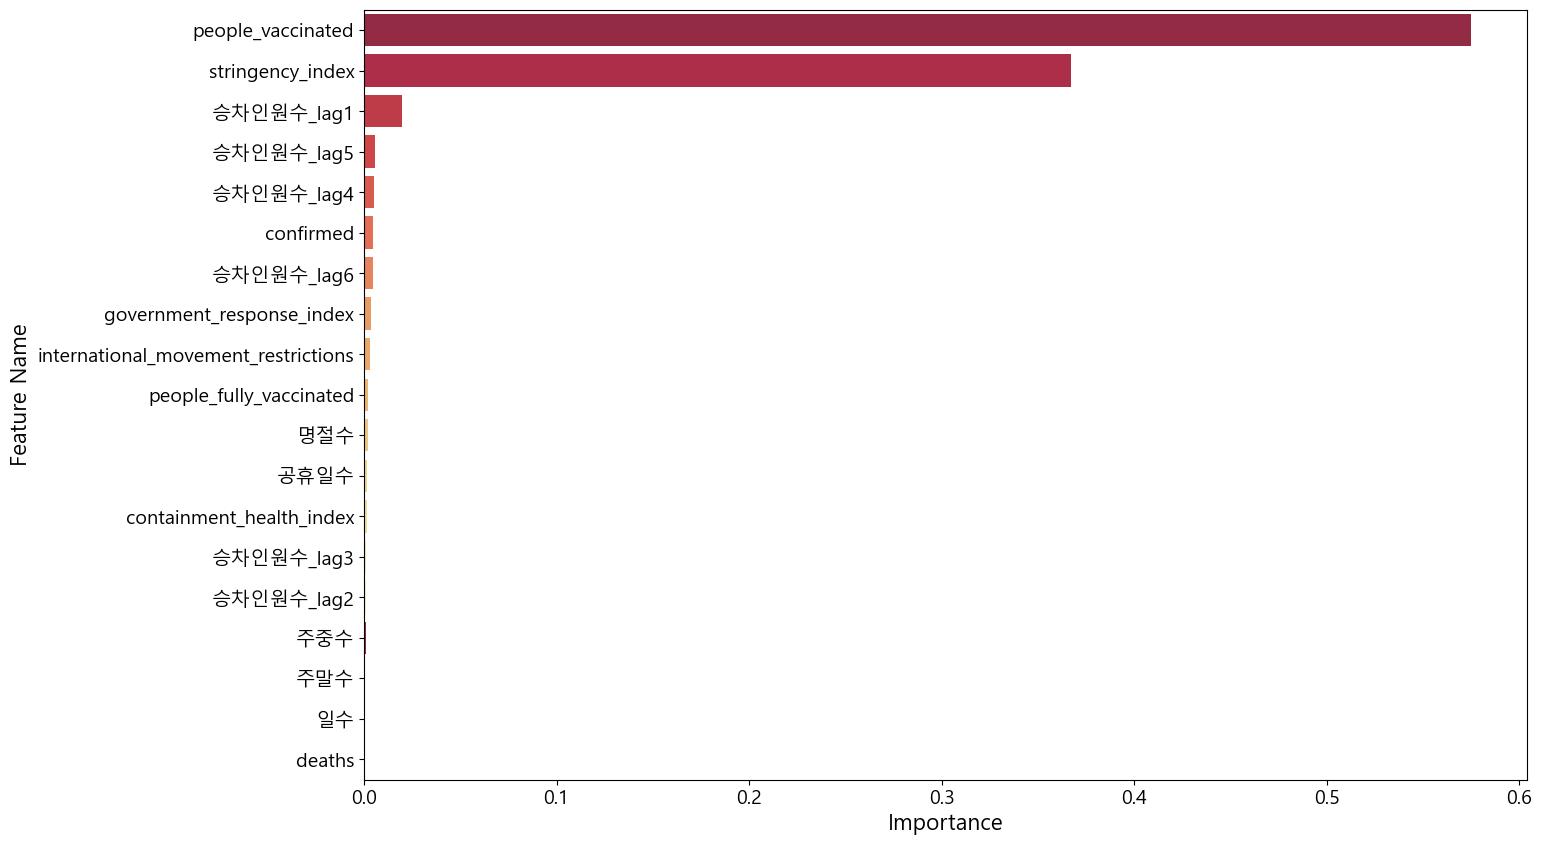

Performance: 


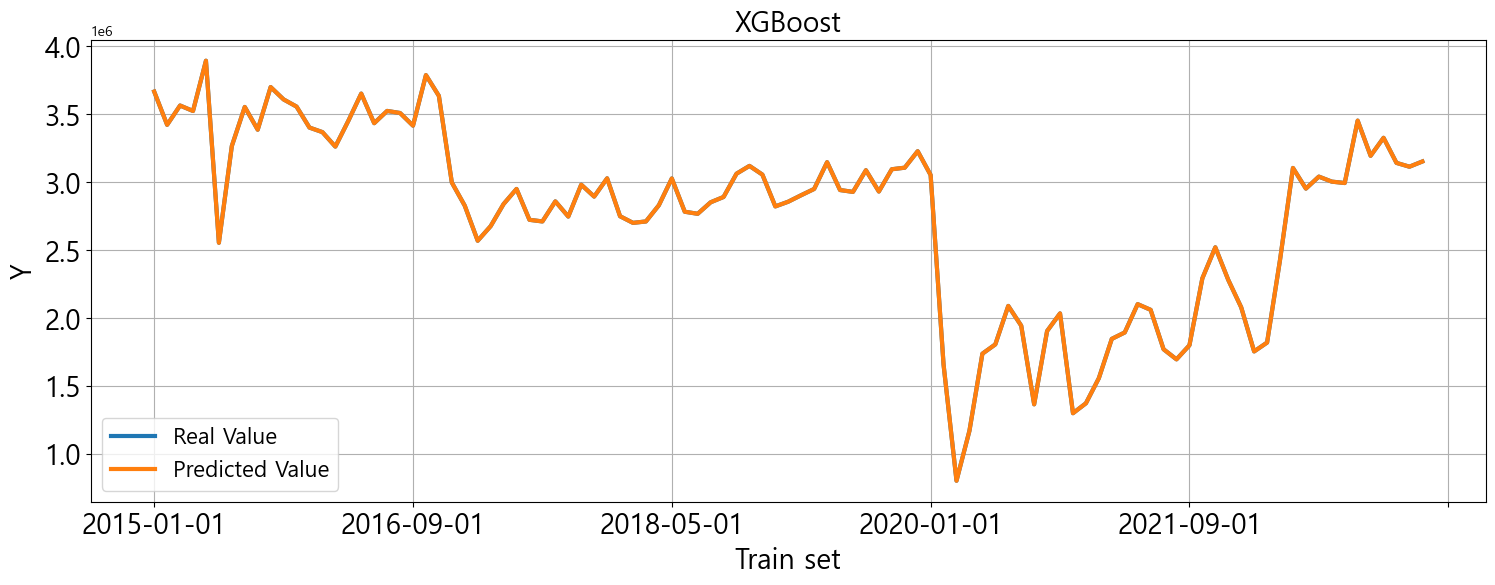

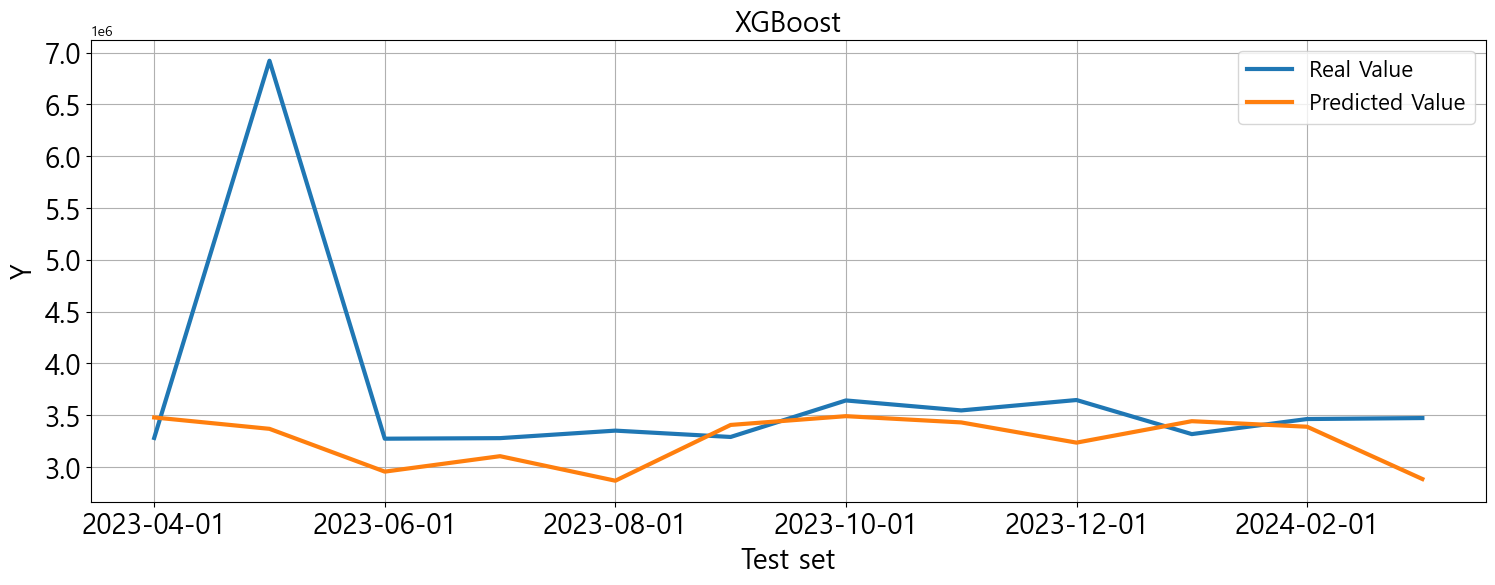

MAE                    MSE   MAPE
Score 525,578.2500 1,133,944,695,938.6875 0.1099

MAE                  MSE   MAPE
Score 56,820.8012 122,588,615,782.9796 0.0119

In [204]:
model_xgb, Score_te_xgb, Score_trte_xgb = modeling_XGBRegressor(X_train, Y_train, X_validate, Y_validate,
                                                                      X_colname, shap=SHAP, X_top_display=X_TOP_DISPLAY)
display(Score_te_xgb, Score_trte_xgb)

## MLP

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 19)]              0         
                                                                 
 dense_105 (Dense)           (None, 128)               2560      
                                                                 
 dropout_108 (Dropout)       (None, 128)               0         
                                                                 
 dense_106 (Dense)           (None, 256)               33024     
                                                                 
 dropout_109 (Dropout)       (None, 256)               0         
                                                                 
 dense_107 (Dense)           (None, 128)               32896     
                                                                 
 dropout_110 (Dropout)       (None, 128)               0  

Training:   0%|                                                                              0/1000 ETA: ?s,  …

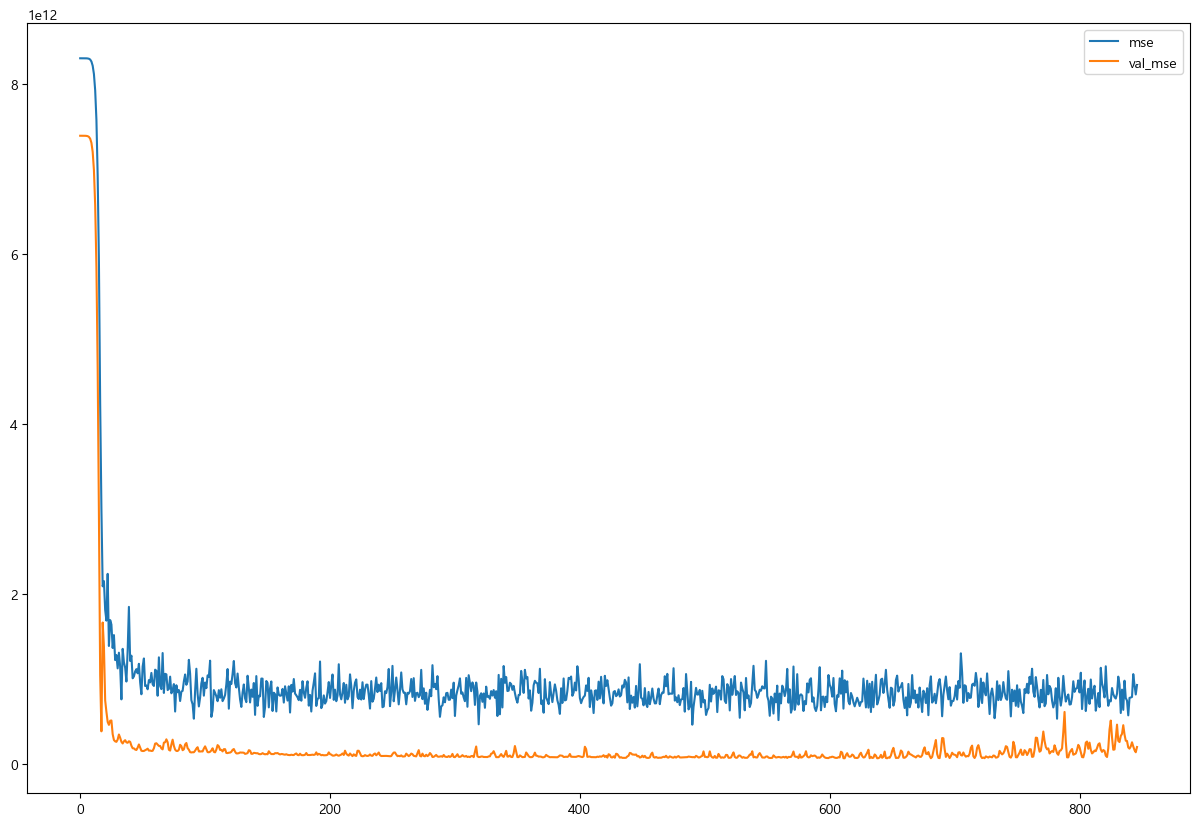

1/1 [==============================] - 0s 12ms/step
Performance: 


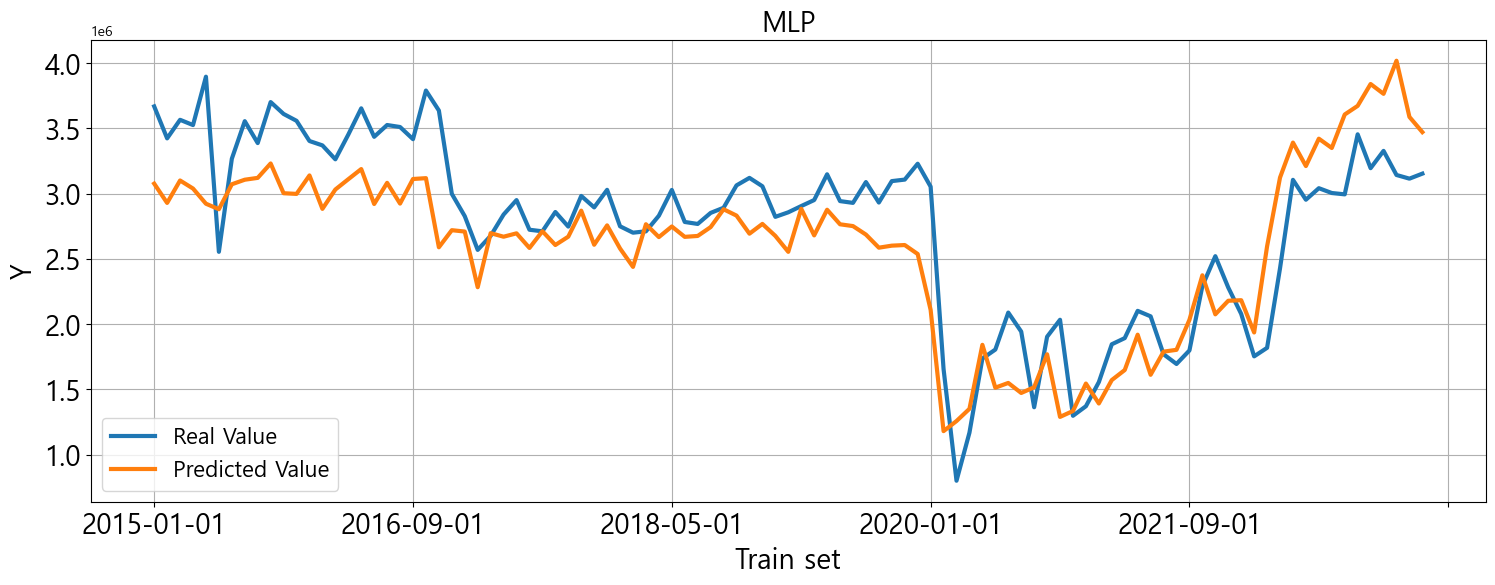

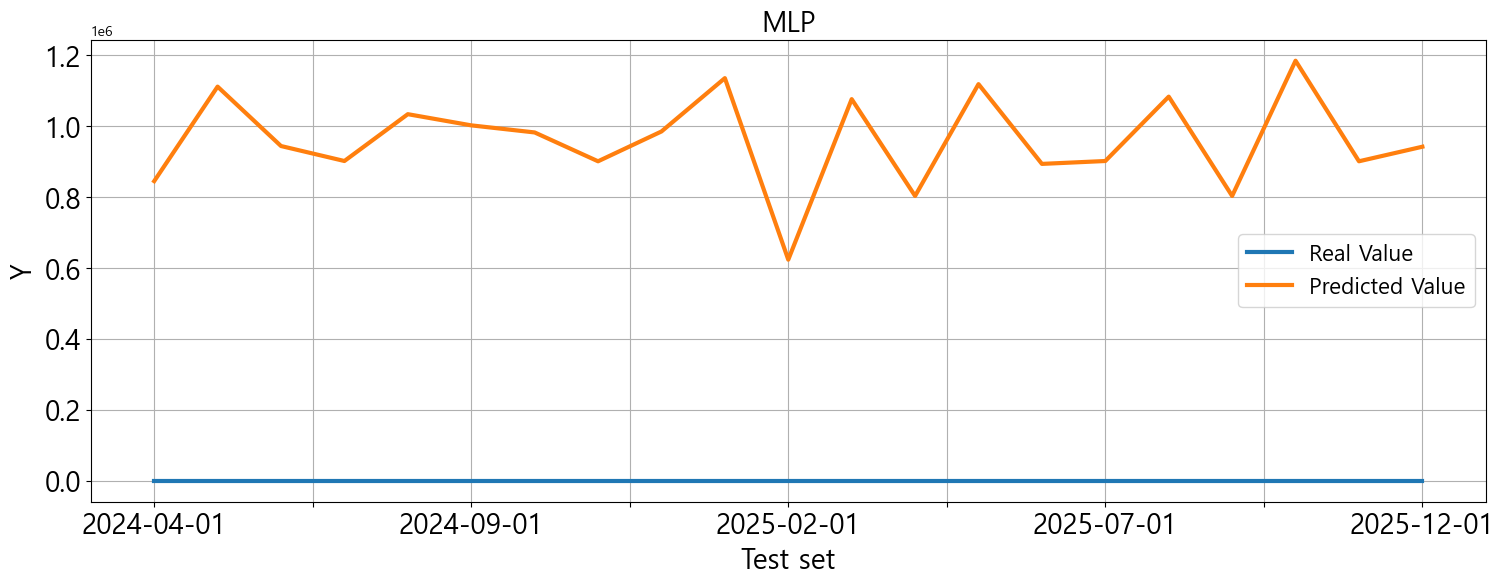

MAE                  MSE                               MAPE
Score 960,213.0327 939,178,553,643.2955 4,324,415,056,435,579,715,584.0000

MAE                  MSE                             MAPE
Score 443,943.5005 297,917,540,208.4172 756,772,634,876,226,437,120.0000

In [205]:
# 모델링
ALGO_NAME='MLP'
model = modeling_MLP(X_train, Y_train,
                     node_MLP=NODE_MLP,
                     HIDDEN_ACTIVATION=HIDDEN_ACTIVATION, OUTPUT_ACTIVATION=OUTPUT_ACTIVATION,
                     REGULARIZER=REGULARIZER, DROPOUT_RATIO=DROPOUT_RATIO,
                     LOSS=LOSS, LEARNING_RATE=LEARNING_RATE, METRICS=METRICS)
model, FILENAME = learning(model, X_train, X_test, Y_train, 
                           VALIDATION_SPLIT=VALIDATION_SPLIT, VALIDATION_DATA=VALIDATION_DATA,
                           BATCH_SIZE=BATCH_SIZE, EPOCHS=EPOCHS, VERBOSE=VERBOSE,
                           MONITOR=MONITOR, MONITOR_MODE=MONITOR_MODE, EARLYSTOP_PATIENT=EARLYSTOP_PATIENT,
                           HISTORY_METRICS=METRICS,
                           shap=False, X_colname=X_colname, X_top_display=X_TOP_DISPLAY)
## 베스트 모델 로딩
model_mlp = load_model(FILENAME)
Score_te_mlp, Score_trte_mlp = prediction_reg(model, X_train, Y_train, X_test, Y_test, ALGO_NAME=ALGO_NAME)
display(model_mlp, Score_te_mlp, Score_trte_mlp)

## CNN

X_train: (99, 19, 1) Y_train: (99, 1)
X_train: (12, 19, 1) Y_train: (12, 1)
X_test: (21, 19, 1) Y_test: (21, 1)
Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 19, 1)]           0         
                                                                 
 conv1d_21 (Conv1D)          (None, 19, 128)           768       
                                                                 
 max_pooling1d_21 (MaxPoolin  (None, 9, 128)           0         
 g1D)                                                            
                                                                 
 dropout_114 (Dropout)       (None, 9, 128)            0         
                                                                 
 conv1d_22 (Conv1D)          (None, 9, 256)            164096    
                                                                 
 max_pooling

Training:   0%|                                                                              0/1000 ETA: ?s,  …

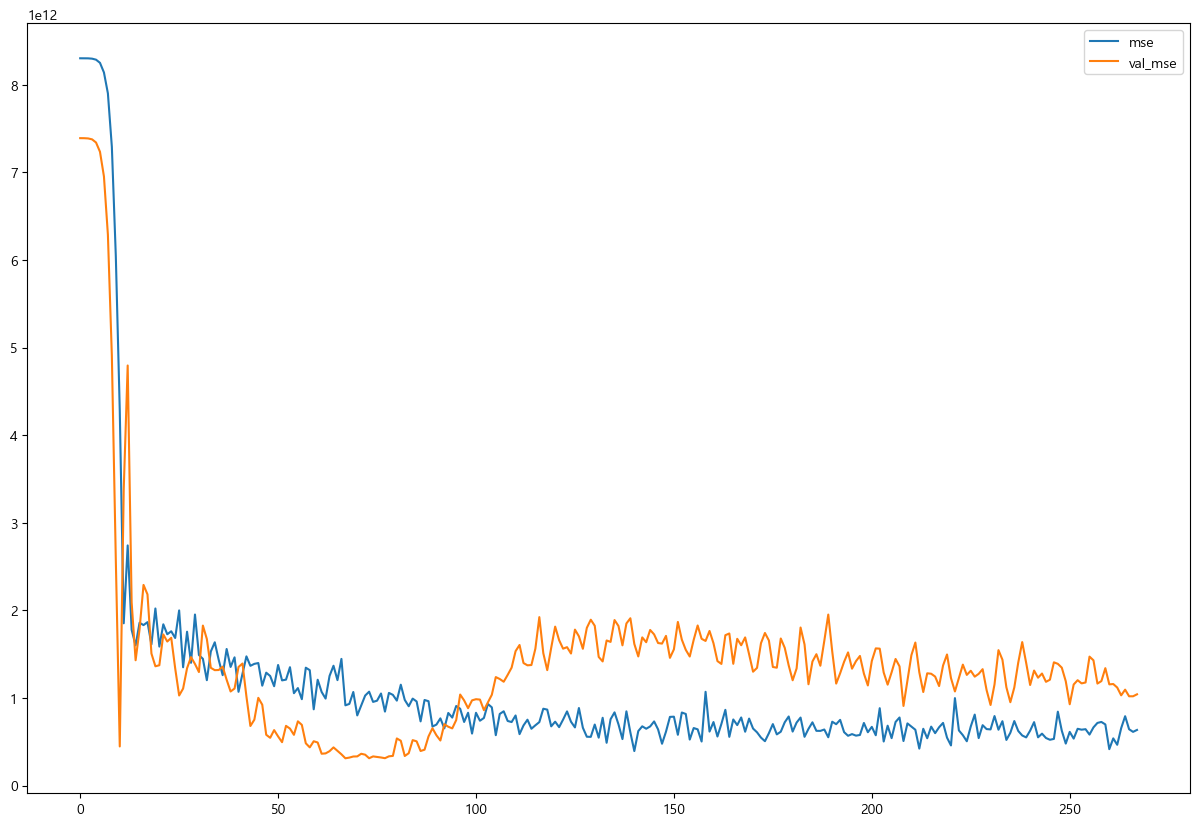

1/1 [==============================] - 0s 15ms/step
Performance: 


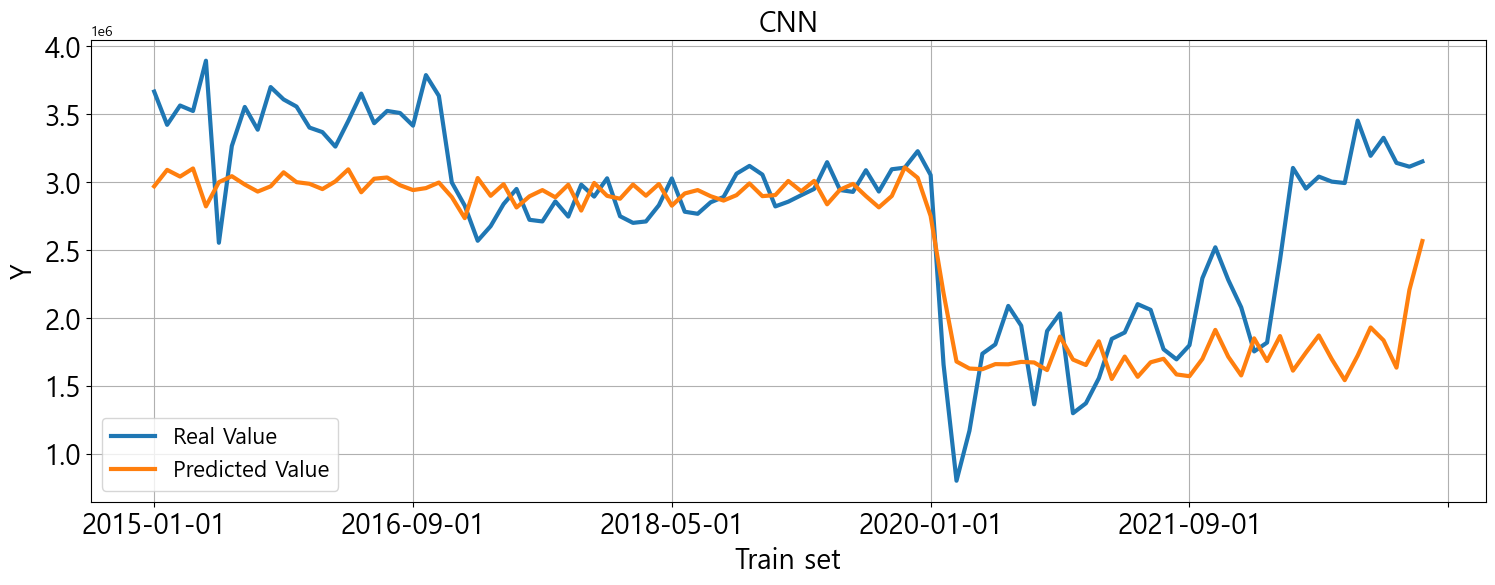

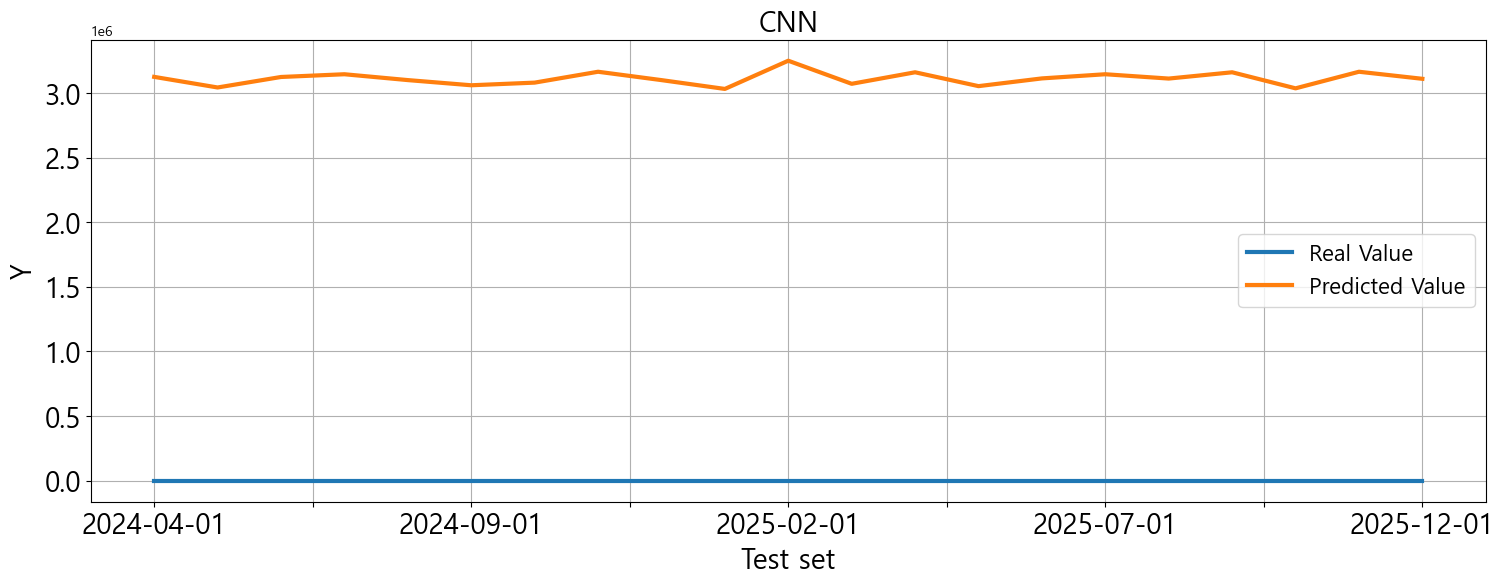

MAE                    MSE  \
Score 3,110,873.6667 9,680,289,193,235.0898   

                                     MAPE  
Score 14,010,129,485,996,687,884,288.0000

MAE                    MSE                               MAPE
Score 889,137.7885 1,959,385,271,473.0405 2,451,772,660,049,420,746,752.0000

In [206]:
# Reshape
X_train = X_train.values.reshape(-1, X_train.shape[1], 1)
X_validate = X_validate.values.reshape(-1, X_train.shape[1], 1)
X_test = X_test.values.reshape(-1, X_test.shape[1], 1)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_train:', X_validate.shape, 'Y_train:', Y_validate.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# 모델링
ALGO_NAME='CNN'
model = modeling_CNN1D(X_train, Y_train,
                       node_CNN1=NODE_CNN1,
                       node_CNN2=NODE_CNN2,
                       HIDDEN_ACTIVATION=HIDDEN_ACTIVATION, OUTPUT_ACTIVATION=OUTPUT_ACTIVATION,
                       KERNEL_SIZE=KERNEL_SIZE, STRIDE=STRIDE, PADDING=PADDING,
                       POOL_SIZE=POOL_SIZE, POOL_STRIDE=POOL_STRIDE,
                       REGULARIZER=REGULARIZER, DROPOUT_RATIO=DROPOUT_RATIO,
                       LOSS=LOSS, LEARNING_RATE=LEARNING_RATE, METRICS=METRICS)
model, FILENAME = learning(model, X_train, X_test, Y_train, 
                           VALIDATION_SPLIT=VALIDATION_SPLIT, VALIDATION_DATA=VALIDATION_DATA,
                            BATCH_SIZE=BATCH_SIZE, EPOCHS=EPOCHS, VERBOSE=VERBOSE,
                            MONITOR=MONITOR, MONITOR_MODE=MONITOR_MODE, EARLYSTOP_PATIENT=EARLYSTOP_PATIENT,
                            HISTORY_METRICS=METRICS,
                            shap=False, X_colname=X_colname, X_top_display=X_TOP_DISPLAY)
## 베스트 모델 로딩
model_cnn = load_model(FILENAME)
Score_te_cnn, Score_trte_cnn = prediction_reg(model, X_train, Y_train, X_test, Y_test, ALGO_NAME=ALGO_NAME)
display(model_cnn, Score_te_cnn, Score_trte_cnn)